In [23]:
from tvb.simulator.lab import *
import numpy as np
from tvb.simulator.backend.dopa_backend import DOPABackend
from tvb.simulator.backend.nb_mpr import NbMPRBackend
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns

In [3]:
# load connectivities
conn_dopamine=np.load("conn_dopamine.npy")
conn_excitator=np.load("conn_excitator.npy")
conn_inhibitor=np.load("conn_inhibitor.npy")

# configure connectivy for TVB
conn = connectivity.Connectivity()
conn.region_labels = np.array(["L.BSTS", "L.CACG", "L.CMFG", "L.CU", "L.EC", "L.FG", "L.IPG", "L.ITG", "L.ICG","L.LOG", "L.LOFG", "L.LG", "L.MOFG", "L.MTG", "L.PHIG", "L.PaCG", "L.POP", "L.POR","L.PTR", "L.PCAL", "L.PoCG", "L.PCG", "L.PrCG", "L.PCU", "L.RACG", "L.RMFG", "L.SFG",
    "L.SPG", "L.STG", "L.SMG", "L.FP", "L.TP", "L.TTG", "L.IN", "L.CER", "L.TH", "L.CA","L.PU", "L.HI", "L.AC", "lh-GPe", "lh-GPi", "lh-STN", "rh-GPe","rh-GPi", "rh-STN", "R.TH", "R.CA", "R.PU", "R.HI",  "R.AC", "R.BSTS",
    "R.CACG", "R.CMFG", "R.CU", "R.EC", "R.FG", "R.IPG", "R.ITG", "R.ICG", "R.LOG","R.LOFG", "R.LG", "R.MOFG", "R.MTG", "R.PHIG", "R.PaCG", "R.POP", "R.POR", "R.PTR","R.PCAL", "R.PoCG", "R.PCG", "R.PrCG", "R.PCU", "R.RACG", "R.RMFG", "R.SFG", "R.SPG",
    "R.STG", "R.SMG", "R.FP", "R.TP", "R.TTG", "R.IN", "R.CER","SubstantiaNigraLH","SubstantiaNigraRH"])
conn.centres = np.zeros((3,88)) # just some trick to create the object in TVB
conn.weights = conn_excitator # inhibitory and dopamine connectivity has to be introduced later (multiple connectivites not implemented in TVB)
conn.tract_lengths = (conn_excitator*.0+100).astype('i') # another trick, we won't be using delays
conn.configure()

# Dopamine model

\begin{align}
\begin{split}
& \frac{dr}{dt} = 2arV + br - (A_{Dp}[D_p]+B_{Dp})g_aS_ar - g_gS_gr + \frac{a\Delta}{\pi} \\
& \frac{dV}{dt} =  aV^2 + bV + c + \eta - \frac{\pi^2  r^2}{a} +(A_{Dp}[D_p]+B_{Dp}) g_aS_a(E_a-V) +g_gS_g(E_g-V)  - u + I_{ext} \\
& \frac{du}{dt} = \alpha(\beta V - u) + u_dr \\
& \frac{dS_g}{dt} = \frac{-S_g}{\tau_{S_g}} + S_{jg}c_{inh} \\ 
& \frac{d[D_p]}{dt} = k c_{dopa}-\frac{V_{max}[D_p]}{(K_m+[D_p])} \\
& \end{split}
\end{align}

Now we have more equations than the Montbrio model. Though not so different because they are constructed from similar single neuron model. We find additional synaptic terms in r and v that are linked to specific connectivity links in the network. Cortical projections are considered excitatory and are the ones we used in the example of Montbrio. Let's lookt at the connectivities :

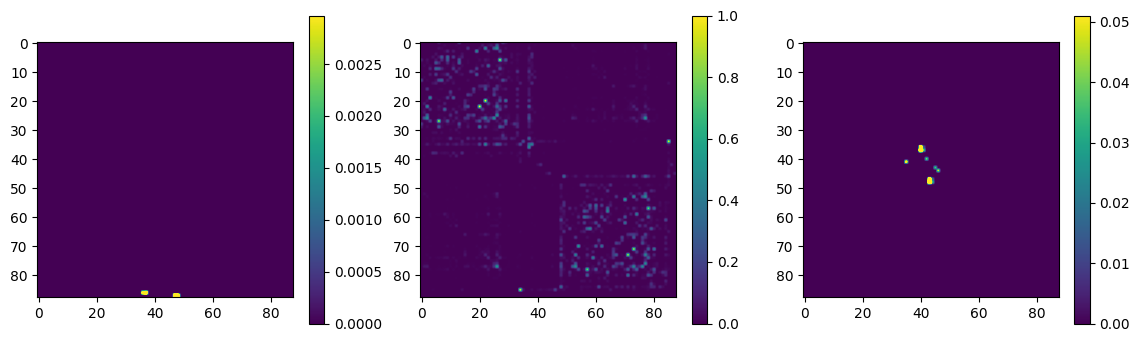

In [4]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5))
im = ax.imshow(conn_dopamine, vmax=conn_dopamine.max()/10)
plt.colorbar(im, shrink=.8, ax=ax)
im2 = ax2.imshow(conn_excitator)
plt.colorbar(im2, shrink=.8, ax=ax2)
im3 = ax3.imshow(conn_inhibitor, vmax=conn_inhibitor.max()/10)
plt.colorbar(im3, shrink=.8, ax=ax3)
plt.show()

The middle one is the one we know. \
The left one are the dopamine connections from the substatia nigra to...?\
The right one are inhibitory connections from ... to ? \
You can look for the answer.

# Let's run a simuation with some starting parameters :

In [5]:
 # For starters we can use most of the defaults parameters
mdl = models.MPRDopa()
# Now we have 3 coupling factors :
g_dopa, g_excit, g_inhib = np.array([9e-1]), 7e-2, np.array([1.7e-2])

nsigma = 0.03
n_nodes = 88
r0, V0, u0, Sa0, Sg0, Dp0 = 0.2, -70.0, 0.0, 0.0, 0.0, 0.05
init_cond = np.array([r0, V0, u0, Sa0, Sg0, Dp0])
initial_cond = np.repeat(init_cond, n_nodes).reshape((1, 6, 88, 1))
r0s = np.random.uniform(high=1., low=0., size=(1, 1, 88, 1))
v0s = np.random.uniform(high=-50., low=-100., size=(1, 1, 88, 1))
initial_cond[:,:1,:,:] = r0s
initial_cond[:,1:2,:,:] = v0s

In [6]:
def configure_sim(ad=0, bd=0, g_excit=None, nsigma=0.03, conn=conn):
    sim = simulator.Simulator(
    model=models.MPRDopa(
        Ad=np.array([ad]),
        Bd=np.array([bd]),
    ),
    connectivity=conn,
    coupling=coupling.Linear(
        a=np.array([g_excit])
    ),
    conduction_speed=1.,
            integrator=integrators.HeunStochastic(
            dt=0.01,
            noise=noise.Additive(
                nsig=np.array(
                    [nsigma,nsigma*10,nsigma/5,nsigma/10, nsigma/10,nsigma/10]
                ), 
                noise_seed=42)
        ),
    monitors=[monitors.Raw()],
    initial_conditions=initial_cond
    ).configure()
    return sim


In [7]:
dopa_backed = DOPABackend()

In [10]:
models.MPRDopa().Ad, models.MPRDopa().Bd

(array([1.]), array([0.2]))

I look at the values of Ad and Bd and see that they are set to 1. and .2 \
Let's run a simulation with values at 0.5 and 0.5 without changing anything else.

In [11]:
sim = configure_sim(ad=0.5, bd=.5, g_excit=7e-2)
(t, tavg), = dopa_backed.run_sim(sim, conn_inhibitor, conn_dopamine, g_inhib, g_dopa, simulation_length=5000)

/Users/martinbreyton/INS_Code/tvb-root/tvb_library/tvb/simulator/backend/dopa_backend.py:127: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  coupling = cx(X, connectivities, g_i, g_e, g_d)


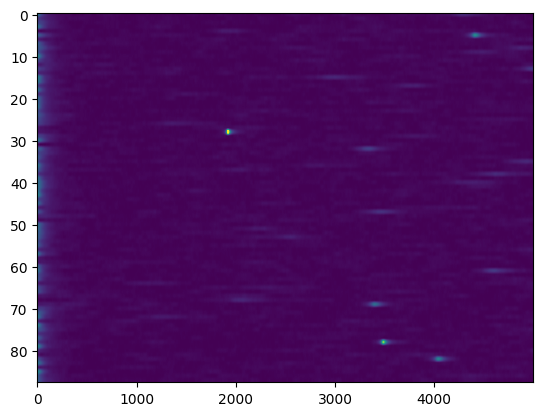

In [12]:
plt.imshow(tavg[:,0,:].T, aspect='auto', vmax=2)

It seems that there is some spike behaviour, let's verify by looking at the node time series where there is a spot

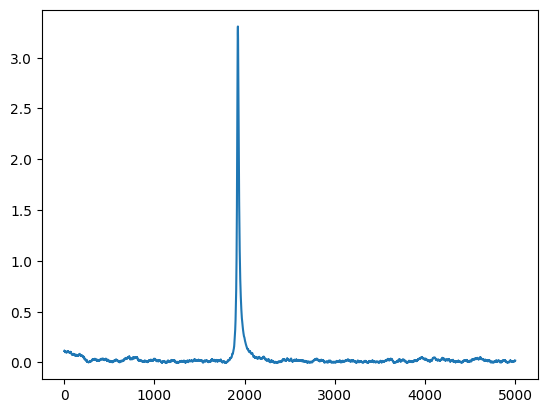

In [13]:
plt.plot(tavg[:,0,28])

Let's find a simple way to calculate if there are a lot of spikes :

In [14]:
np.sum(tavg[:,0,:]>1)/n_nodes

0.8522727272727273

Now let's vary Ad and Bd simutaneously between 0 and 1 with a step of .2 and calculate our metric:

In [16]:
rslt = []
for i, (ad, bd) in enumerate(product(np.arange(0,1,.2), np.arange(0,1,.2))):
    sim = configure_sim(ad=ad, bd=bd, g_excit=7e-2)
    (t, tavg), = dopa_backed.run_sim(sim, conn_inhibitor, conn_dopamine, g_inhib, g_dopa, simulation_length=5000)    
    rslt.append((ad, bd, np.sum(tavg[:,0,:]>1)/n_nodes))
    print(f'{i+1}/{len(list(product(np.arange(0,1,.2), np.arange(0,1,.2))))}', end='\r')


Text(0, 0.5, 'Bd')

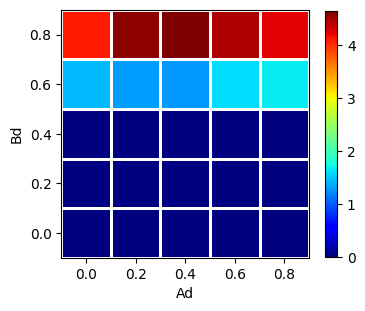

In [29]:
X,Y = np.meshgrid(np.arange(0,1,.2), np.arange(0,1,.2), indexing='ij')
metric = np.array(rslt)[:,2].reshape((5, 5))
fig, ax = plt.subplots(1, 1, figsize=(4,4))
im = ax.pcolormesh(X, Y, metric, edgecolors='w',cmap="jet")
plt.colorbar(im, shrink=.8)
ax.set_aspect('equal')
ax.set_xlabel('Ad')
ax.set_ylabel('Bd')

Okay, so it seems that if we keep Bd below 0.6 nothing really happens in the network. \
Now maybe we want to push Bd and Ad further up to see what happens, and discard values of Bd below .4 (It's good too keep at least one value of the low boundary I think)? \
Then we can redo the same and change one other parameter... step by step...